----
## Работа со сломанными пикселями

В представленном датасете битые пиксели выражаются в пикселях либо абсолютно чёрных, либо абсолютно белых. Очевидно их наличие значительно осложняет обучении модели и с ними необходимо бороться.
<br>Также стоит отметить низкое качество изображений из датасета, что наводит на мысли о максимальной минимализации потерь при обработке - при работе с битыми пикселями нужно сохранить максимальное количество исходных данных.
<br>Исходя из этих умозаключений отметаются сложные варианты удаления шума, более эффективные на больших изображениях, но потенциально способные сильно исказить данные на малом объёме. 
<br>Нужен простой и эффективный метод, который будет с минимальными потерями восстанавливать изображение.

- Теоритическое обоснование разработанного метода:

Нужно стремиться к минимальному искажению изображения, поэтому работать мы будем только с битыми пикселями, идентифицируя их по абсолютным значениям (255, 255, 255), (0, 0, 0).
<br>Что делать с найденными битыми пикселями? - заменять на среднее арифмитеческое ближайших соседей. 
<br>Однако что делать если соседи тоже битые? - при подсчёте среднего арифметического учитывать только нормальные пиксели.

- Практическая реализация:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
def is_broken_pixel(rgb_color):
    return np.array_equal(rgb_color, [1., 1., 1.]) or np.array_equal(rgb_color, [0., 0., 0.])


def get_average_pixel(image, i, j):
    pixels_bunch = image[i - 1:i + 2, j - 1:j + 2, :]
    good_pixels_summ = np.zeros(3)
    good_pixels_count = 0
    for i in range(len(pixels_bunch)):
        for j in range(len(pixels_bunch)):
            if not is_broken_pixel(pixels_bunch[i, j]):
                good_pixels_summ += pixels_bunch[i, j]
                good_pixels_count += 1
    if good_pixels_count == 0:
        return good_pixels_summ
    return good_pixels_summ / good_pixels_count


def repair_image(image):
    padding_image = np.full((len(image[0]) + 2, len(image[0]) + 2, 3), 0.)
    padding_image[:, :, 0] = np.pad(image[:, :, 0], pad_width=1, constant_values=0.)
    padding_image[:, :, 1] = np.pad(image[:, :, 1], pad_width=1, constant_values=0.)
    padding_image[:, :, 2] = np.pad(image[:, :, 2], pad_width=1, constant_values=0.)
    for i in range(1, len(padding_image) - 1):
        for j in range(1, len(padding_image) - 1):
            if is_broken_pixel(padding_image[i, j]):
                padding_image[i, j] = get_average_pixel(padding_image, i, j)
    return padding_image[1: -1, 1: -1, :]

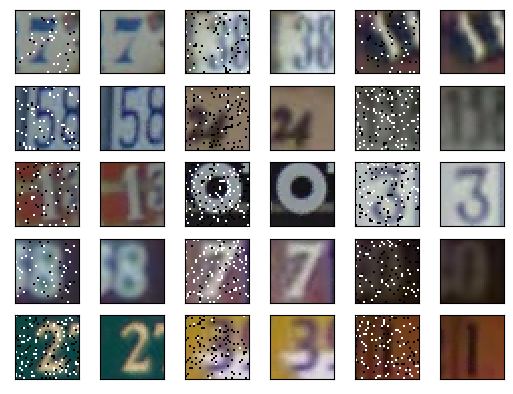

In [19]:
f = open('data/data_train', 'rb')
cl = pickle.load(f)
images = cl["images"]/255

f, visual = plt.subplots(5, 6)
random_indexes = np.random.randint(len(images), size=25)
for i in range(5):
    for j in range(0, 5, 2):
        image = images[random_indexes[i * 5 + j]].copy()
        visual[i][j].imshow(image, interpolation='nearest')
        visual[i][j].get_xaxis().set_ticks([])
        visual[i][j].get_yaxis().set_ticks([])
        visual[i][j+1].get_xaxis().set_ticks([])
        visual[i][j+1].get_yaxis().set_ticks([])
        visual[i][j + 1].imshow((repair_image(image)), interpolation='nearest')
plt.show()

Вывод: метод оправдал ожидания и вполне эффективно справляется со своей задачей.